In [50]:
# 모듈로딩
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

import torch
import torch.nn as nn            # LinearRegression기능의 클래스
import torch.nn.functional as F  # 손실함수
import torch.optim as optim      # 경사하강법 기반의 최적화 관련 모듈

In [51]:
# 데이터 준비
fashion_db = 'fashion-mnist'
fashion_data = fetch_openml(name = fashion_db, parser = 'auto')  # as_frame = False로 설정하면 넘파이로 데이터 받는다.

In [52]:
# 데이터 확인
feature = fashion_data['data']
target = fashion_data['target']

In [53]:
# 피처와 타겟 개수 확인
print(f'FEATURE => {feature.shape}, {feature.ndim}D')
print(f'TARGET => {target.shape}, {target.ndim}D')

FEATURE => (70000, 784), 2D
TARGET => (70000,), 1D


In [54]:
# 분류 확인
print(f"FEATURE NAME => {fashion_data['feature_names']}\n")
print(f"TARGET NAME => {fashion_data['target_names']}\n")
print(f"CATEGORIES NAME => {fashion_data['categories']}\n")  # 데이터를 넘파이로 받으면 값 반환
print(f"CATEGORIES => {target.unique()}")

FEATURE NAME => ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'p

[2] 데이터 가공 및 전처리 <hr>
- 결측치/중복/이상치 => 없음
- 다중분류 => 2진분류 변환 : target 변환
- 표준화 => 이미지 동일 크기 및 색상 : 동일 크기와 채널
- 정규화 => 피처 정규화 / 타겟 정규화 

In [55]:
# [2-1] 다중분류 ===> 2진분류 => target 변환
target = target == '0'
target.unique()

array([False,  True])

In [56]:
# [2-2] 정규화 ===> 피처 : 784개 색상값 즉, 0 ~ 255 범위 값
norm_feature = feature / 255.

[3] 학습 준비 <hr>
- 데이터 텐서화
- 데이터셋 준비 : 훈련용, 테스트용
- 학습 방법 : 지도학습 - 이진분류 => Linear 클래스 + sigmoid 함수
- 최적화 방법: 경사하강법
- 손실 함수 : 이진 분류 손실 계산 함수 => binary_cross_entropy 

In [57]:
# 데이터셋 준비 : 60000개 훈련, 10000개 테스트
limit = 60000
train = norm_feature.iloc[:limit]
test = norm_feature.iloc[limit:]

train_y = target[:limit]
test_y = target[:limit]

In [58]:
print(f'train => {train.shape}, {train.ndim}D,  {train_y.shape}, {train_y.ndim}D')
print(f'test => {test.shape}, {test.ndim}D,  {test_y.shape}, {test_y.ndim}D')

train => (60000, 784), 2D,  (60000,), 1D
test => (10000, 784), 2D,  (60000,), 1D


In [59]:
# 텐서로 변환
X_train = torch.FloatTensor(train.values) 
X_test = torch.FloatTensor(test.values)

y_train = torch.FloatTensor(train_y.values).unsqueeze(dim = 1)
y_test = torch.FloatTensor(test_y.values).unsqueeze(dim = 1)

In [60]:
print(f'train => {X_train.shape}, {X_train.ndim}D,  {y_train.shape}, {y_train.ndim}D')
print(f'test => {X_test.shape}, {X_test.ndim}D,  {y_test.shape}, {y_test.ndim}D')

train => torch.Size([60000, 784]), 2D,  torch.Size([60000, 1]), 2D
test => torch.Size([10000, 784]), 2D,  torch.Size([60000, 1]), 2D


In [61]:
# 학습 인스턴스 생성
in_, out_ = X_train.shape[1], y_train.shape[1]
model = nn.Linear(in_, out_)
model

Linear(in_features=784, out_features=1, bias=True)

In [62]:
# 최적화 인스턴스 생성 => 모델에서 사용하는 W, b 변수들 전달
optimizer = optim.Adam(model.parameters())

In [63]:
# 학습 횟수 => 샘플 처음부터 끝까지 읽는 것을 기준으로 횟수 지정
EPOCHS = 150

[4] 학습 <hr>
- 반복 횟수만큼 학습 진행

In [64]:
loss_accuaray = [[], []]
for ep in range(EPOCHS):
    # 학습
    pre_y = model(X_train)
    print(f'예측값 : {pre_y}')
    # 분류값 변환
    pre_y2 = F.sigmoid(pre_y)
    # print(f'분류값 : {pre_y2}')

    # 오차 즉 손실 계산
    loss = F.binary_cross_entropy(pre_y2, y_train)
    loss_accuaray[0].append(round(loss.item(), 2))
    print(f'[{ep}] Loss => {round(loss.item(), 2)}')

    # W, b 업데이트
    optimizer.zero_grad()
    loss.backward()   # 손실함수 계산값으로 미분 진행하여 새로운 W, b 계산
    optimizer.step()  # 새로운 값으로 W, b 업데이트

    # 정확도 계산 => 예측값을 0과 1로 변환 => 정답과 비교
    train_accuracy = (y_train == (pre_y2 >= 0.5)).sum() / y_train.shape[0]
    loss_accuaray[1].append(round(train_accuracy.item(), 2))
    print(f'훈련 정확도 => {round(train_accuracy.item(), 2)}')

예측값 : tensor([[0.0306],
        [0.4939],
        [0.0984],
        ...,
        [0.2982],
        [0.2551],
        [0.1056]], grad_fn=<AddmmBackward0>)
[0] Loss => 0.81
훈련 정확도 => 0.13
예측값 : tensor([[-0.2694],
        [ 0.1611],
        [-0.0150],
        ...,
        [ 0.0520],
        [ 0.1227],
        [ 0.0392]], grad_fn=<AddmmBackward0>)
[1] Loss => 0.71
훈련 정확도 => 0.4
예측값 : tensor([[-0.5675],
        [-0.1685],
        [-0.1276],
        ...,
        [-0.1925],
        [-0.0085],
        [-0.0269]], grad_fn=<AddmmBackward0>)
[2] Loss => 0.63
훈련 정확도 => 0.75
예측값 : tensor([[-0.8619],
        [-0.4913],
        [-0.2386],
        ...,
        [-0.4335],
        [-0.1369],
        [-0.0922]], grad_fn=<AddmmBackward0>)
[3] Loss => 0.56
훈련 정확도 => 0.87
예측값 : tensor([[-1.1506],
        [-0.8029],
        [-0.3470],
        ...,
        [-0.6689],
        [-0.2607],
        [-0.1564]], grad_fn=<AddmmBackward0>)
[4] Loss => 0.51
훈련 정확도 => 0.9
예측값 : tensor([[-1.4315],
        [-1.0987],
    

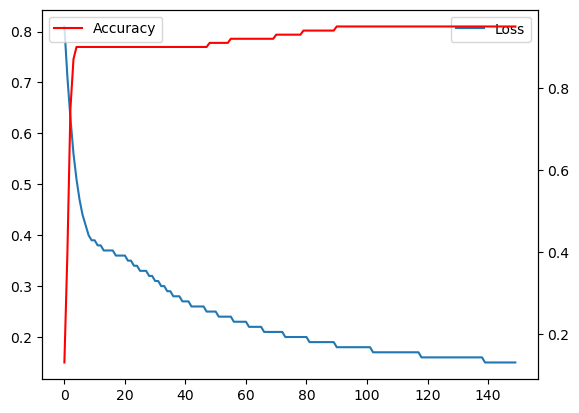

In [65]:
# 손실과 정확도 시각화
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(loss_accuaray[0], label = 'Loss')
plt.legend()
ax2 = ax1.twinx()
ax2.plot(loss_accuaray[1], label = 'Accuracy', color = 'red')
plt.legend()
plt.xlabel('Epochs')
plt.show()